# Exercise:  Gauss Histogram Fitting 

This example shows how to fit an histogram using ROOT 

Create First an empty histogram with 50 bins with range [-10,10]

In [1]:
TH1D h1("h1","h1",50,-10,10);

Fill the histogram with 10000 Gaussian Random number with mean=1 and sigma=2

In [2]:
for (int i = 0; i < 1000; ++i) {
    h1.Fill(gRandom->Gaus(1,2));
}

Note, we could also use the function h1.FillRandom("gaus"), but we need to set the right parameters of the Gaussian function before.

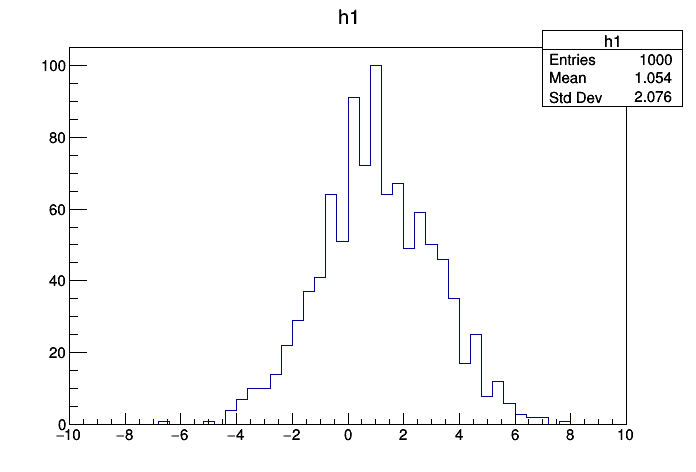

Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


In [3]:
h1.Draw();
gPad->Draw();

### Part1: Fit the Histogram with a Gaussian function

Note that before fitting we need to create the fitting function and set its initial parameter values. 
For a Gaussian function the setting of initial values is not really needed, because they can be computed automatically by ROOT. 

In [4]:
// declare here some variables which will be used afterwards
TF1 * f1 = nullptr; 
TFitResultPtr res; 

Create the Gaussian Fit function

In [5]:
f1 = new TF1("f1","gaus",-10,10);

Set the initial parametger values (e.g. Constant = 100, mean = 0, sigma =1)

In [6]:
f1->SetParameters(100,0,1);  

Fit now the histogram using the Fit method in ROOT. By default the least-square method is used. 
For likelihood fits we need to use the option "L", for Pearson chi-square (expected error) , option "P".

Use also  option "S" to create a TFitResult object that is returned to the user.
To compute the error using MINOS, use the "E" option


In [7]:
res  = h1.Fit(f1, "S  E");

 FCN=35.8313 FROM MINOS     STATUS=SUCCESSFUL     21 CALLS         171 TOTAL
                     EDM=4.34905e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.40284e+01   3.02687e+00  -2.34163e-02   1.36540e-04
   2  Mean         1.02275e+00   6.85129e-02  -4.53464e-04  -6.98304e-03
   3  Sigma        2.08774e+00   5.45912e-02   5.45912e-02   8.36253e-02


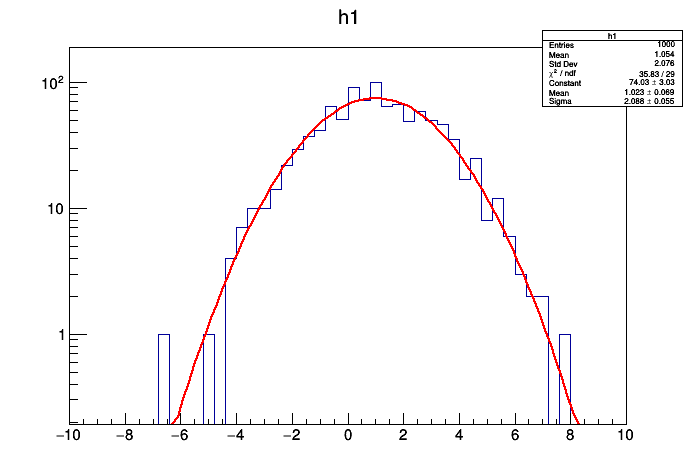

In [8]:
gStyle->SetOptFit(1);
gPad->SetLogy(true); // to set log scale in y
gPad->Draw();

Print the result of the Fit from the returned TFitResult object

In [9]:
res->Print();


****************************************
Minimizer is Minuit / Migrad
Chi2                      =      35.8313
NDf                       =           29
Edm                       =  4.34905e-11
NCalls                    =           84
Constant                  =      74.0284   +/-   3.02687     
Mean                      =      1.02275   +/-   0.0685129   
Sigma                     =      2.08774   +/-   0.0545912    	 (limited)


Get the correlation matrix of the fit from the TFitResult class and print it 

In [10]:
auto corrMatrix = res->GetCorrelationMatrix(); 
corrMatrix.Print(); 


3x3 matrix is as follows

     |      0    |      1    |      2    |
--------------------------------------------
   0 |          1    0.007838     -0.6161 
   1 |   0.007838           1    -0.02071 
   2 |    -0.6161    -0.02071           1 



In [11]:
std::cout  << "Gaussian sigma = " << f1->GetParameter("Sigma") << "  +/- " << f1->GetParError(f1->GetParNumber("Sigma")) << std::endl;

Gaussian sigma = 2.08774  +/- 0.0545912


If we want to access the MINOS asymmetric error, we can get them from the FitResult object

In [12]:
std::cout  << "Gaussian sigma = " << res->Parameter(2) << "  + " << res->UpperError(2) << "  " << res->LowerError(2) << std::endl;

Gaussian sigma = 2.08774  + 0.0547402  -0.0544955


### Part 2:  Fit Bias Study

We study now the Fit Bias for the sigma parameter. We can look at the difference obtained by using 3 different fit methods: 

1. Chisquare fit using the observed error (default case in ROOT) 
2. Chisquare fit using the expected error (option "P" - Pearson chi2)
3. Binned maximum likelihood fit (option "L")

In [13]:
TH1 * hs = nullptr;

In [14]:
hs = new TH1D("hs","Sigma pull distribution",50,-4,4);

Generate 1000 pseudo-experiments, where for each one of them generate an histogram as above (50 bins, in [-10,10] and fill it with 1000 Gaussian distributed numbers with $\mu=1$ and $\sigma=2$. 
For each pseudo-experiment, fit the histogram and look at the obtained $\sigma$ value from the fit. 
Fill the *Sigma pull histogram*, *hs* with $(\sigma_{FIT} - \sigma_{TRUE})/\sigma_{FIT-ERROR}$. 

$\sigma_{TRUE} = 2$ in this case and $\sigma_{FIT-ERROR}$ is the uncertainty obtained from the fit.

Do for one of the three cases (Neyman chi2 (default), Likelihood fit (option *L*) or Pearson chi2 (option *P*)

In [15]:
hs->Reset(); // in case we run a second time
for (int iexp = 0; iexp < 1000; ++iexp) { 
    TH1D h0("h0","h0",50,-10,10);
    for (int i = 0; i < 1000; ++i){
        h0.Fill(gRandom->Gaus(0,2));
    }
    TF1 f1("f1","gaus",-10,10);
    f1.SetParameters(100,0,1);
    h0.Fit(&f1,"Q  P");  // use Q option to avoid too much printing
    hs->Fill( (f1.GetParameter(2)- 2)/f1.GetParError(2));  // to get sigma and its error
    //std::cout << f1.GetParameter(2) << " " << f1.GetParError(2) << std::endl;
}

Fit the obtained Pull distribution with a Gaussian function

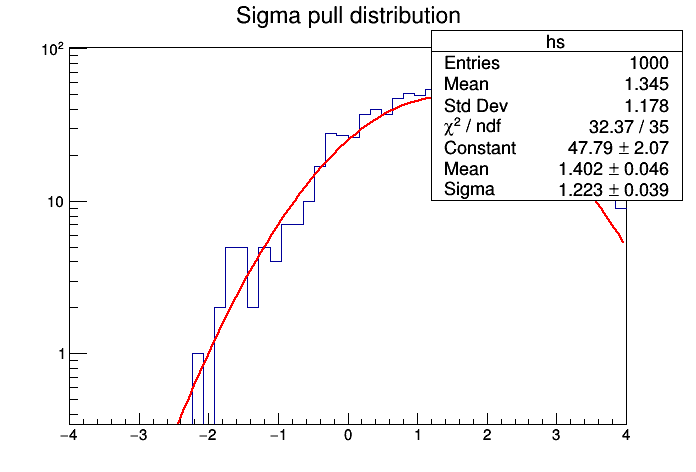

 FCN=32.371 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=1.4494e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.77878e+01   2.06837e+00   4.49853e-03  -2.90941e-04
   2  Mean         1.40233e+00   4.61836e-02   1.22136e-04   3.40332e-03
   3  Sigma        1.22251e+00   3.85109e-02   2.22971e-05  -1.84078e-02


In [16]:
hs->Fit("gaus"); gPad->Draw();

### Part 3:  Study the chi2 distribution

Using the likelihood definition described in the Baker-Cousins paper we can use the likelihood at the minimum as a chi2. We study its distribution using pseudo-experiments.
We can compare what we obtain if we use the likelihood-value in a likelihood fit or the chi2 obtained when doing a
chi2 Fit (Neyman or Pearson chi2). 

In [17]:
TH1 * hchi = nullptr;
TF1 * fchi = nullptr; 

In [18]:
hchi = new TH1D("hchi","chi-squared distribution",100,0,100);

The Baker-Cousins likelihood-value is obtained from the FitResult class as 
$2 \times$ *result->MinFcnValue()*
*result->Chi2()* returns instead the Chi2 obtained from the data-function resuduals.

Genersate now 10000 pseudo-experiments and for each of them create, fill and fit an histogram as before. 
But now make an histogram of the chi2 distribution, either using *2 result->MinFcnValue()* if doing a likelihood fit or
using *result->Chi2()* in case of a chi2 fit

In [24]:
hchi->Reset(); // in case we run a second time
for (int iexp = 0; iexp < 10000; ++iexp) { 
    TH1D h0("h0","h0",50,-10,10);
    for (int i = 0; i < 1000; ++i){
        h0.Fill(gRandom->Gaus(0,4));
    }
    TF1 f1("f1","gaus",-10,10);
    f1.SetParameters(100,0,1);
    // for likelihood fits 
    auto r = h0.Fit(&f1,"S Q L ");  // use Q option to avoid too much printing
    hchi->Fill( 2.* r->MinFcnValue() );  // to get likelihood value from fit result
    // uncomment these lines for chi2 fits and comment the two lines above
    //auto r = h0.Fit(&f1,"S Q ");  // use Q option to avoid too much printing
    //hchi->Fill( r->Chi2 () );  //  get chi2 value from fit result
}

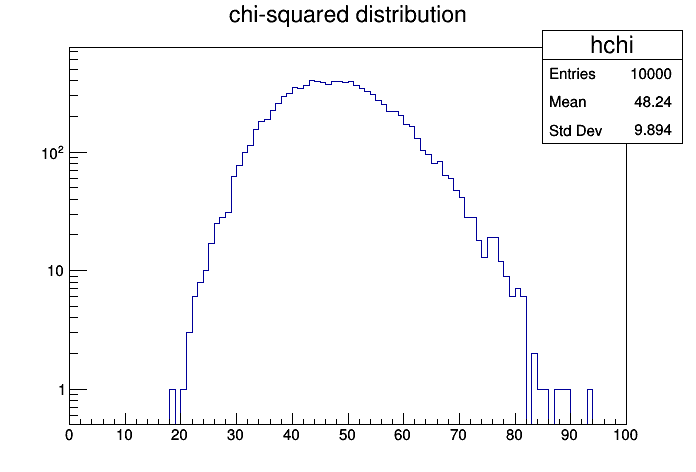

In [25]:
hchi->Draw(); gPad->Draw();

In [26]:
fchi = new TF1("fchi","[0]*ROOT::Math::chisquared_pdf(x,[1])",0,100);
fchi->SetParameters(hchi->GetEntries()*hchi->GetBinWidth(1), hchi->GetMean());

In [27]:
hchi->Fit(fchi,"L");

 FCN=29.3947 FROM MIGRAD    STATUS=CONVERGED      27 CALLS          28 TOTAL
                     EDM=1.66139e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00002e+04   1.00002e+02   3.77444e-01   1.40646e-07
   2  p1           4.82226e+01   9.72016e-02   3.66991e-04  -3.93589e-04
                               ERR DEF= 0.5


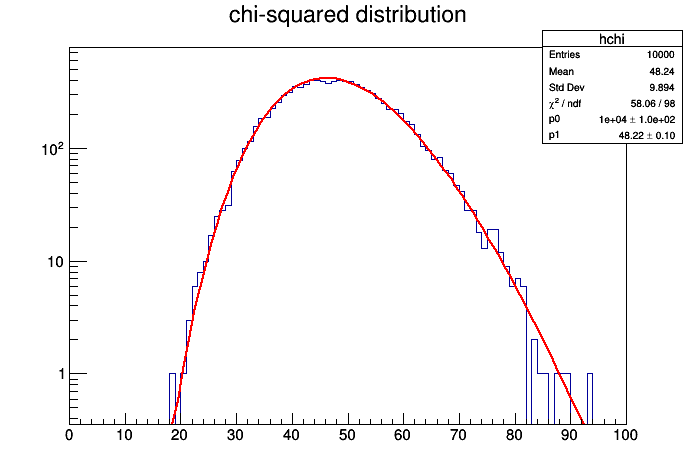

In [28]:
hchi->Draw(); gPad->Draw();

Which of the two obtained quantities (Baker-Cousins lieklihood or Neyman chi2) agree better with a real chi2 distribution ? 